# Baseline Autoencoder Anomaly Detection Demo

##1. Import the Necessary Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError, Reduction
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from functools import partial
from re import X

In [2]:
repo_url = "https://github.com/dzakialaqsha/autoencoder-benford-analysis.git"
!git clone {repo_url}

Cloning into 'autoencoder-benford-analysis'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 9.52 MiB | 4.11 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
#import utility functions from repo
%cd "/content/autoencoder-benford-analysis/utils"
import data_preprocessing
import model_building

/content/autoencoder-benford-analysis/utils


In [4]:
fraud_data = pd.read_csv('/content/autoencoder-benford-analysis/data/fraud_dataset_v1.csv')

In [5]:
sampled_fraud_data = data_preprocessing.benford_distribution_preserving_sampling(fraud_data, 'HKONT', 'DMBTR', 50000)
sampled_fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50050 entries, 0 to 50049
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WAERS   50050 non-null  object 
 1   BUKRS   50050 non-null  object 
 2   KTOSL   50050 non-null  object 
 3   BELNR   50050 non-null  object 
 4   BSCHL   50050 non-null  object 
 5   HKONT   50050 non-null  object 
 6   DMBTR   50050 non-null  float64
 7   WRBTR   50050 non-null  float64
 8   label   50050 non-null  object 
dtypes: float64(2), object(7)
memory usage: 3.4+ MB


In [6]:
sampled_fraud_data = pd.concat([sampled_fraud_data, fraud_data[fraud_data.label == "global"], fraud_data[fraud_data.label == "local"]], axis='rows')
old_data = sampled_fraud_data.copy()
sampled_fraud_data.value_counts('label')

,count
label,
regular,49979
global,140
local,31


In [7]:
sampled_fraud_data = sampled_fraud_data.drop(['label'], axis='columns')
np_sampled_fraud_data = data_preprocessing.data_preprocessing(sampled_fraud_data, ['WAERS', 'BUKRS', 'KTOSL', 'BELNR', 'BSCHL', 'HKONT'], ['DMBTR', 'WRBTR'])

In [8]:
np_sampled_fraud_data

array([[9.99999672e-01, 9.99999815e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.18017849e-02, 1.18066500e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.98122293e-03, 1.70193656e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.85057976e-03, 9.13532957e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.85076514e-03, 9.13681232e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.85048305e-03, 9.13810929e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## 2. Build the Model

In [9]:
autoencoder_model = model_building.build_autoencoder(input_dim=np_sampled_fraud_data.shape[1], latent_dim=2)
autoencoder_model.summary()

Model: "Functional_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 618)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       158,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_5 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_6 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_7 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent_Space (Dense)            │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_5 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_6 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_7 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reconstruction_Output (Dense)   │ (None, 618)            │       158,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,428 (1.55 MB)

 Trainable params: 405,428 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0240
Epoch 2/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0044
Epoch 3/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0040
Epoch 4/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0040
Epoch 5/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0040
Epoch 6/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0036
Epoch 7/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0035
Epoch 8/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0035
Epoch 9/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0035
Epoch 10/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0033
Epoch 11/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0032
Epoch 12/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0030
Epoch 13/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0028
Epoch 14/15
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0027
Epoch 15/15


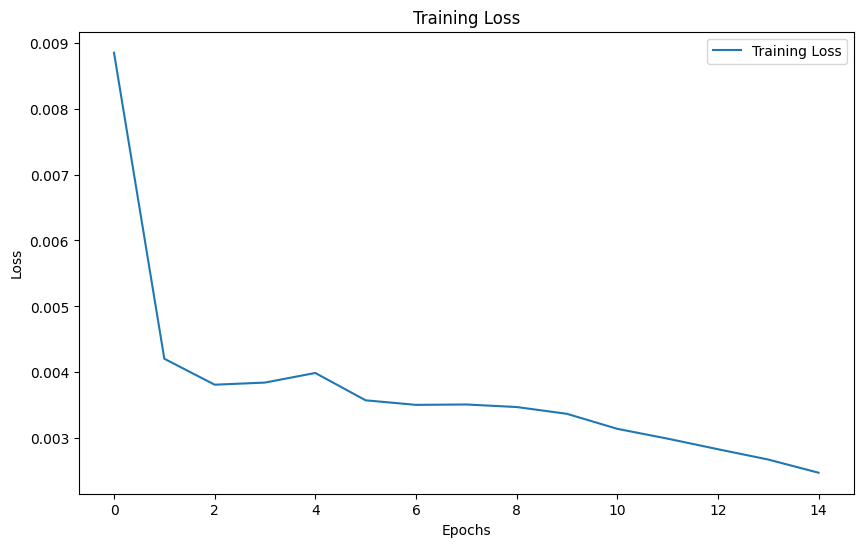

In [10]:
history, reconstructions, individual_mse, fig = model_building.train_autoencoder(autoencoder_model, np_sampled_fraud_data, 15, 32, 0.001)

<Axes: ylabel='Count'>

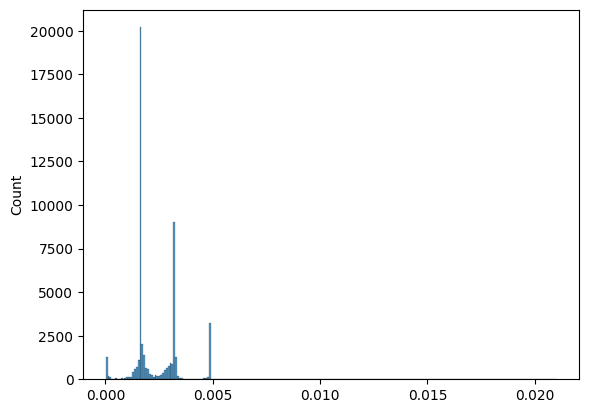

In [11]:
sns.histplot(individual_mse)

In [12]:
old_data['label'] = old_data['label'].isin(['global','local']).astype(int)

In [13]:
old_data.head(20)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label
0,J73,K76,Q44,K32,H00,A42,9.244551e+07,5.958505e+07,1
1,C9,C90,C1,C18,A2,B1,1.091040e+06,7.035000e+03,0
2,C2,C28,C1,C10,A1,B1,1.831726e+05,1.014100e+04,0
3,C1,C19,C5,C58,A1,B1,1.154395e+06,0.000000e+00,0
4,C7,C70,C1,C15,A3,B1,1.537143e+06,0.000000e+00,0
5,C1,C18,C5,C59,A1,B1,1.253433e+06,2.883750e+05,0
6,C1,C19,C1,C11,A1,B1,1.398734e+05,0.000000e+00,0
7,C2,C20,C1,C19,A1,B1,1.292003e+06,5.962400e+04,0
8,C1,C17,C1,C16,A1,B1,1.633361e+05,2.108800e+04,0
9,C1,C15,C9,C99,A1,B1,1.090806e+05,0.000000e+00,0


In [14]:
percentile = float(np.percentile(individual_mse, 99.75))
heaviside_prediction_data = model_building.heaviside_step_function(old_data, individual_mse, percentile)
heaviside_prediction_data.head(15)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label,reconstruction_error,predicted_label
0,J73,K76,Q44,K32,H00,A42,9.244551e+07,5.958505e+07,1,0.017647,1
1,C9,C90,C1,C18,A2,B1,1.091040e+06,7.035000e+03,0,0.001726,0
2,C2,C28,C1,C10,A1,B1,1.831726e+05,1.014100e+04,0,0.001680,0
3,C1,C19,C5,C58,A1,B1,1.154395e+06,0.000000e+00,0,0.003236,0
4,C7,C70,C1,C15,A3,B1,1.537143e+06,0.000000e+00,0,0.001773,0
5,C1,C18,C5,C59,A1,B1,1.253433e+06,2.883750e+05,0,0.003237,0
6,C1,C19,C1,C11,A1,B1,1.398734e+05,0.000000e+00,0,0.001618,0
7,C2,C20,C1,C19,A1,B1,1.292003e+06,5.962400e+04,0,0.000020,0
8,C1,C17,C1,C16,A1,B1,1.633361e+05,2.108800e+04,0,0.001618,0
9,C1,C15,C9,C99,A1,B1,1.090806e+05,0.000000e+00,0,0.004854,0


In [15]:
heaviside_prediction_data.value_counts('label')

,count
label,
0,49979
1,171


In [16]:
heaviside_prediction_data.value_counts('predicted_label')

,count
predicted_label,
0,50024
1,126


In [17]:
accuracy, precision, recall, f1, confusion_mat = model_building.evaluate_prediction(heaviside_prediction_data, 'label', 'predicted_label')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9991026919242273
Precision: 1.0
Recall: 0.7368421052631579
F1 Score: 0.8484848484848485
